# Hackathon Day 2
Today we want to train a Convolutional Neural Network for classifying pneumonia on the [PneumoniaMNIST](https://medmnist.com/) dataset


**Learning Outcome:** Learn how to
- define training and model parameters and analyse their influence on model performance
- write a training loop
- evaluate classification performance using different performance metrics 

# Task 1: Load dataset 
Use the code from day 1 to load your dataset.\
If you worked on this yesterday, you can also use data augmentation methods. Data augmentation is a technique used to increase the diversity of training data by applying random transformations, like rotating, flipping, or cropping images, to create new variations of existing data. This helps improve a model’s ability to generalize and perform better on unseen data.\
For data augmentation you can use the [MONAI library](https://docs.monai.io/en/stable/transforms.html)

In [1]:
# import some libraries we will need 

from medmnist import PneumoniaMNIST 
import numpy as np
import torch
import random
from matplotlib import pyplot as plt
import torch.nn as nn
from monai.data import DataLoader, CacheDataset
from monai.utils import  GridSamplePadMode
from monai.transforms import (
    Compose,
    RandAffined,
    RandFlipd,
    RandGaussianNoised,
    ScaleIntensityd,
    EnsureTyped,
)

/home/admin_ml/anaconda3/envs/namt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_transforms = Compose(
    [
        EnsureTyped(keys=['image'], data_type='tensor'),
        ScaleIntensityd(keys=['image'], minv=0, maxv=1 )
    ] )

# Optional: Apply Data Augmentation:
# You can also randomly rotate or flip your dataset, apply gaussian noise, etc. to create more variability in the dataset 
# see https://docs.monai.io/en/stable/transforms.html
train_transforms = Compose(
    [
        EnsureTyped(keys=['image'], data_type='tensor'),
        RandFlipd(
            keys = ['image'],
            prob = 0.25,
            spatial_axis=1),
        RandAffined(
            keys = ['image'],
            mode = ('bilinear'),
            prob = 0.5, 
            shear_range = 0.1,
            spatial_size = [224,224],
            rotate_range = np.pi/180*20,
            scale_range = 0.1,
            padding_mode = GridSamplePadMode.BORDER), 
        RandGaussianNoised(
            keys = ['image'],
            prob = 0.25, 
            std = 0.1,
            ),
        ScaleIntensityd(keys=['image'], minv=0, maxv=1 )
    ])
    

# If you want to use Monai data transformations you have to use this class
# to convert medmnist dataset to a format compatible with MONAI
class WrappedPneumoniaMNIST(PneumoniaMNIST):
    def __getitem__(self, index):
        #data = super().__getitem__(index)
        image, label = super().__getitem__(index)
        image = torch.tensor(np.array(image)).unsqueeze(0)
        return {"image": image, "label": label}

# Load Pneumonia datase for training, validation and test
size=224
train_dataset = WrappedPneumoniaMNIST(split="train",download=True, size=size)
val_dataset = WrappedPneumoniaMNIST(split="val",download=True, size=size)
test_dataset = WrappedPneumoniaMNIST(split="test",download=True, size=size)

# Wrap with MONAI CacheDataset
# Attention: If you use data augmentation, only apply it to training data and not to the validation and test set as we want to keep them unchanged.
train_monai_dataset = CacheDataset(data=train_dataset, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_monai_dataset = CacheDataset(data=val_dataset, transform=data_transforms, cache_rate=1.0, num_workers=4)
test_monai_dataset = CacheDataset(data=test_dataset, transform=data_transforms, cache_rate=1.0, num_workers=4)

Using downloaded and verified file: /home/admin_ml/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /home/admin_ml/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /home/admin_ml/.medmnist/pneumoniamnist_224.npz


Loading dataset: 100%|██████████| 624/624 [00:00<00:00, 2011.49it/s]


In [4]:
# Next: initiliaze train_loader, val_loader and test_loader using DataLoader from MONAI
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_monai_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_monai_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_monai_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Task 2: Define training and model parameters
- We want to train a classification model. You can for example use the **ResNet18** model. To initialize the model you can use [Monai](https://docs.monai.io/en/stable/networks.html#nets). 
- Moreover, we have to define our training parameters, as optimizer, loss function and learning rate. 
- For a binary classification problem you can for example use binary cross entropy loss (see [here](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)). 
- As optimizer you can use stochastic gradient descent (see [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) 

Carry out several experiments and vary the model parameters. What effect does this have on the model performance?\
You can use, for example, a larger model (e.g. ResNet 50), and vary the learning rate and the batch size. Write down your observations.  
For quick experiments, you can work with the small data set (28x28). Ultimately, however, you should train a model on one of the higher-resolution data sets (64x64 or 224x224). 

**Solution:**
When training a Convolutional Neural Network (CNN), several parameters significantly influence the performance, efficiency, and final outcome of the model. Understanding how variations in these parameters affect training can help you fine-tune your model for better accuracy, faster convergence, and more effective generalization.

1. **Learning Rate**:\
    The learning rate is a critical hyperparameter that controls the size of the steps the model takes when updating its weights based on the gradient of the loss function.

- Too high learning rate:
    - The model takes large steps towards the minimum of the loss function.
    - This can lead to overshooting the optimal solution, causing the loss to oscillate or even diverge.    
    - Training might become unstable, and the model might fail to converge.
- Too low learning rate:
    - The model takes very small steps, leading to slow convergence.
    - Training can take much longer, and the model might get stuck in a local minimum, potentially not reaching the best possible solution.
    - The risk of overfitting increases since the model might focus too much on the training data details.
- Optimal learning rate:
    - Achieves a good balance, allowing the model to converge efficiently.  
    - Helps the model reach a good minimum in the loss landscape, resulting in better performance.

2. **Model Size**:\
    The size of the model is determined by the number of layers and the number of neurons / filters in each layer.\
    Advantages of using a larger model:
    - Can capture more complex patterns in the data due to a higher capacity (more parameters).
    - Often performs better on large, complex datasets.
    Disadvantages of using a larger model:
    - Requires more computational resources (memory and processing power).
    - Takes longer to train.
    - More prone to overfitting, especially if the dataset is small or not sufficiently diverse.

3. **Batch Size**:\
    The batch size is the number of training examples used to calculate the gradient during one iteration of the training process.

    Advantages of using a larger batch size:
    - Produces smoother and more stable gradient estimates, leading to faster convergence.
    
    Disadvantages of using a larger batch size:
    - Requires more memory, which can be a limitation on certain hardware.
    - More prone to getting stuck in local minima, leading to potential overfitting and reduced generalization ability.



In [5]:
from monai.networks.nets import resnet18, resnet50

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50(spatial_dims=2, num_classes=1, n_input_channels=1).to(device) #resnet18(spatial_dims=2,num_classes=1,n_input_channels=1).to(device)
# You can also use num_classes = 2 and change the activation function to softmax instead of sigmoid.
# With one class and sigmoid activation function the output of the network is transformed to a probability x
# with x < 0.5 = no pneumonia and x >= 0.5 = pneumonia.
criterion = nn.BCEWithLogitsLoss()

NUM_EPOCHS = 500

lr=0.001 
wd=0.001 
# You can use weight decay as a penalty term for the model weights. 
# This penalty term prevents the weights from becoming to large and thus helps the model not only to memorize the training data, 
# but also to learn general patterns that can be applied to new data (prevents overfitting)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=wd) 

# Task 3: Evaluation function 
- Use [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) to evaluate your model
- For a classification task you can for example use metrics like AUC, Accuracy, F1-Score, Sensitivity and Specificity

What exactly do the individual metrics mean? How can you interpret the results?

**Solution**:
1. Accuracy
    - Accuracy is the proportion of correctly predicted instances (both positives and negatives) out of the total number of instances.
    - A higher accuracy means that more predictions are correct.
    - However, accuracy can be misleading if the data is imbalanced (e.g., if there are many more negatives than positives).
2. AUC (Area Under the Curve)
    - Specifically, it refers to the Area Under the ROC (Receiver Operating Characteristic) Curve. The ROC curve plots the true positive rate (Sensitivity) against the false positive rate (1 - Specificity).
    - The AUC ranges from 0 to 1. A score closer to 1 indicates a better model that distinguishes between positive and negative classes effectively.
    - An AUC of 0.5 suggests the model is no better than random guessing.
3. Sensitivity (Recall)
    - The proportion of actual positives that the model correctly identifies (true positives out of all positives).
    - High Sensitivity means the model correctly identifies most of the positive cases.
    - It’s important in situations where missing a positive case is costly (e.g., diagnosing a disease).
4. Specificity
    - The proportion of actual negatives that the model correctly identifies (true negatives out of all negatives).
    - High Specificity means the model correctly identifies most of the negative cases.
    - It’s crucial in situations where false positives are problematic (e.g., false alarms in a security system).
5. F1-Score
    - The harmonic mean of Precision and Recall (Sensitivity).
    - Precision is the proportion of true positives out of all predicted positives.
    - The F1-Score balances Precision and Recall, making it useful when you want to consider both false positives and false negatives.
    - It's especially helpful when the classes are imbalanced.

In [6]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score
    )

def evalModel(y_true, y_score, thresh=0.5):
    y_true = y_true.squeeze() # ground truth class / label
    y_score = y_score.squeeze() # probabilities 

    y_pred = (y_score > thresh).astype(int) # predicted class

    metric_dict = {}

    metric_dict['Acc'] = accuracy_score(y_true, y_pred)
    metric_dict['F1'] =  f1_score(y_true=y_true, y_pred=y_pred, zero_division = 0)
    metric_dict['Sensitivity'] = recall_score(y_true=y_true, y_pred=y_pred, zero_division = 0)
    metric_dict['Specificity'] = recall_score(y_true=y_true, y_pred=y_pred, zero_division = 0, pos_label=0)    
    metric_dict['AUC'] = roc_auc_score(y_true, y_score)

    return metric_dict

# Task 4: Training loop
A training loop is the repetitive process in which a model learns from data by iteratively passing batches through the network, calculating loss, updating weights using an optimizer, and repeating until the model converges or a set number of iterations is reached.

In [7]:
import os
import time
from tqdm import tqdm 

final_model_path = os.path.join(os.path.dirname(os.path.realpath('__file__')),f'finalModel_{NUM_EPOCHS}_Epochs_size_{size}.model')
best_model_path = os.path.join(os.path.dirname(os.path.realpath('__file__')),f'bestModel_{NUM_EPOCHS}_Epochs_size_{size}.model')

# to save performances 
writer_dict = {'epoch': [],
               'loss_train': [],
               'loss_valid': [],
               'lr': [],
               'Acc': [],
               'F1': [],
               'Sensitivity': [],
               'Specificity': [],
               'AUC': []}

train_loss = []
val_loss = []

min_valid_loss = None
scaler = torch.amp.GradScaler() 
# https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
# Gradient scaling helps prevent gradients with small magnitudes from flushing to zero (“underflowing”) when training with mixed precision.

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
  
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        with torch.autocast(device_type='cuda'):
        
            inputs = batch['image'].to(device) # move to gpu
            targets = batch['label'].to(device,torch.float16)
        
            outputs = model(inputs)
                    
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss.append(loss.item())
    
    lr = optimizer.param_groups[0]['lr']
    writer_dict['lr'].append(lr)
    
    if epoch == NUM_EPOCHS-1:
        # You can use this code to save your model
        state_dict = model.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()

        torch.save({
            'epoch': epoch,
            'save_dir': final_model_path,
            'state_dict': state_dict,
            'optimizer_state_dict': optimizer.state_dict()},
            final_model_path)

    # Now we want to evaluate our model on the validation data
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for batch in val_loader:
            with torch.autocast(device_type='cuda'):

                inputs = batch['image'].to(device)
                targets = batch['label'].to(device, torch.float16)
                outputs = model(inputs)
            
            val_loss.append(criterion(outputs, targets).item())

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs.sigmoid()), 0) # sigmoid to transform outputs from logits to probabilites 
    
    y_true = y_true.cpu().numpy()
    y_score = y_score.detach().cpu().numpy()

    
    # Save best model on validation set 
    if epoch == 0:
        min_valid_loss = np.mean(val_loss)
        state_dict = model.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()

        torch.save({
            'epoch': epoch,
            'save_dir': best_model_path,
            'state_dict': state_dict,
            'optimizer_state_dict': optimizer.state_dict()},
            best_model_path)
            
    elif np.mean(val_loss) < min_valid_loss:
        min_valid_loss = np.mean(val_loss)
        state_dict = model.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()
    
        torch.save({
            'epoch': epoch,
            'save_dir': best_model_path,
            'state_dict': state_dict,
            'optimizer_state_dict': optimizer.state_dict()},
            best_model_path)
    
    # to monitor model performance  
    writer_dict['epoch'].append(epoch)
    writer_dict['loss_train'].append(np.mean(train_loss))
    writer_dict['loss_valid'].append(np.mean(val_loss))

    metric_dict_val = evalModel(y_true,y_score)

    for cur_key in metric_dict_val.keys():
        writer_dict[cur_key].append(metric_dict_val[cur_key])
    
    end_time = time.time()
 
    print('Epoch %03d, time for epoch: %3.2f' %(epoch, end_time-start_time))
    print('loss %2.4f, validation loss %2.4f, Val AUC: %3f, Val F1: %3f' %(np.mean(train_loss), np.mean(val_loss), metric_dict_val['AUC'], metric_dict_val['F1']))   

100%|██████████| 74/74 [01:12<00:00,  1.01it/s]


Epoch 000, time for epoch: 75.08
loss 0.5091, validation loss 36.0087, Val AUC: 0.500000, Val F1: 0.000000


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 001, time for epoch: 152.14
loss 0.4191, validation loss 18.3662, Val AUC: 0.910378, Val F1: 0.708197


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 002, time for epoch: 154.32
loss 0.3610, validation loss 13.3787, Val AUC: 0.954508, Val F1: 0.156398


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 003, time for epoch: 151.89
loss 0.3291, validation loss 10.1149, Val AUC: 0.917195, Val F1: 0.902564


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 004, time for epoch: 152.38
loss 0.3073, validation loss 8.1406, Val AUC: 0.953213, Val F1: 0.936118


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 005, time for epoch: 157.76
loss 0.2912, validation loss 7.0666, Val AUC: 0.647425, Val F1: 0.414487


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 006, time for epoch: 162.67
loss 0.2792, validation loss 6.1014, Val AUC: 0.972522, Val F1: 0.912863


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 007, time for epoch: 166.42
loss 0.2691, validation loss 5.3719, Val AUC: 0.946330, Val F1: 0.932806


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 008, time for epoch: 74.38
loss 0.2593, validation loss 5.9985, Val AUC: 0.710159, Val F1: 0.015306


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 009, time for epoch: 74.75
loss 0.2505, validation loss 5.4302, Val AUC: 0.969199, Val F1: 0.906077


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 010, time for epoch: 74.29
loss 0.2428, validation loss 5.7616, Val AUC: 0.566714, Val F1: 0.163934


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 011, time for epoch: 168.81
loss 0.2367, validation loss 5.3009, Val AUC: 0.957726, Val F1: 0.926893


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 012, time for epoch: 163.66
loss 0.2301, validation loss 5.0177, Val AUC: 0.747263, Val F1: 0.547135


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 013, time for epoch: 163.89
loss 0.2260, validation loss 4.6905, Val AUC: 0.968266, Val F1: 0.883191


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 014, time for epoch: 166.25
loss 0.2203, validation loss 4.3941, Val AUC: 0.979996, Val F1: 0.941606


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 015, time for epoch: 169.23
loss 0.2159, validation loss 4.1501, Val AUC: 0.967828, Val F1: 0.878745


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 016, time for epoch: 173.89
loss 0.2120, validation loss 3.9147, Val AUC: 0.980358, Val F1: 0.959079


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 017, time for epoch: 175.32
loss 0.2085, validation loss 3.7123, Val AUC: 0.974902, Val F1: 0.919728


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 018, time for epoch: 174.41
loss 0.2052, validation loss 3.5250, Val AUC: 0.981005, Val F1: 0.957606


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 019, time for epoch: 172.38
loss 0.2014, validation loss 3.3574, Val AUC: 0.984043, Val F1: 0.951380


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 020, time for epoch: 174.32
loss 0.1980, validation loss 3.2040, Val AUC: 0.981729, Val F1: 0.961637


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 021, time for epoch: 175.04
loss 0.1947, validation loss 3.0648, Val AUC: 0.985804, Val F1: 0.969849


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 022, time for epoch: 173.42
loss 0.1913, validation loss 2.9689, Val AUC: 0.967124, Val F1: 0.802450


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 023, time for epoch: 173.96
loss 0.1886, validation loss 2.8525, Val AUC: 0.981881, Val F1: 0.962687


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 024, time for epoch: 174.78
loss 0.1860, validation loss 2.7429, Val AUC: 0.988070, Val F1: 0.970323


100%|██████████| 74/74 [01:13<00:00,  1.00it/s]


Epoch 025, time for epoch: 175.37
loss 0.1832, validation loss 2.6491, Val AUC: 0.951119, Val F1: 0.924005


100%|██████████| 74/74 [01:14<00:00,  1.01s/it]


Epoch 026, time for epoch: 177.15
loss 0.1805, validation loss 2.5551, Val AUC: 0.986423, Val F1: 0.971795


100%|██████████| 74/74 [01:14<00:00,  1.01s/it]


Epoch 027, time for epoch: 175.55
loss 0.1778, validation loss 2.4691, Val AUC: 0.988260, Val F1: 0.969925


100%|██████████| 74/74 [01:13<00:00,  1.00it/s]


Epoch 028, time for epoch: 174.65
loss 0.1752, validation loss 2.3885, Val AUC: 0.982681, Val F1: 0.975672


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 029, time for epoch: 173.79
loss 0.1731, validation loss 2.3180, Val AUC: 0.986290, Val F1: 0.932065


100%|██████████| 74/74 [01:13<00:00,  1.00it/s]


Epoch 030, time for epoch: 173.98
loss 0.1708, validation loss 2.2501, Val AUC: 0.984957, Val F1: 0.948655


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 031, time for epoch: 176.62
loss 0.1690, validation loss 2.1834, Val AUC: 0.985242, Val F1: 0.971867


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 032, time for epoch: 174.88
loss 0.1670, validation loss 2.1210, Val AUC: 0.990593, Val F1: 0.969925


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 033, time for epoch: 175.06
loss 0.1650, validation loss 2.0638, Val AUC: 0.972160, Val F1: 0.959688


100%|██████████| 74/74 [01:13<00:00,  1.00it/s]


Epoch 034, time for epoch: 176.15
loss 0.1629, validation loss 2.0079, Val AUC: 0.989289, Val F1: 0.975672


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 035, time for epoch: 172.52
loss 0.1611, validation loss 1.9573, Val AUC: 0.982215, Val F1: 0.949735


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 036, time for epoch: 175.69
loss 0.1596, validation loss 1.9089, Val AUC: 0.986375, Val F1: 0.962687


100%|██████████| 74/74 [01:13<00:00,  1.01it/s]


Epoch 037, time for epoch: 176.66
loss 0.1580, validation loss 1.8621, Val AUC: 0.985023, Val F1: 0.967742


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 038, time for epoch: 174.66
loss 0.1563, validation loss 1.8249, Val AUC: 0.970808, Val F1: 0.921801


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 039, time for epoch: 174.90
loss 0.1547, validation loss 1.7867, Val AUC: 0.985414, Val F1: 0.932854


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 040, time for epoch: 173.99
loss 0.1532, validation loss 1.7463, Val AUC: 0.989308, Val F1: 0.972362


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 041, time for epoch: 174.62
loss 0.1516, validation loss 1.7075, Val AUC: 0.991231, Val F1: 0.976040


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 042, time for epoch: 173.45
loss 0.1502, validation loss 1.6705, Val AUC: 0.989355, Val F1: 0.974684


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 043, time for epoch: 173.87
loss 0.1490, validation loss 1.6346, Val AUC: 0.990784, Val F1: 0.980843


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 044, time for epoch: 171.52
loss 0.1476, validation loss 1.6003, Val AUC: 0.990879, Val F1: 0.975547


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 045, time for epoch: 172.81
loss 0.1461, validation loss 1.5677, Val AUC: 0.989241, Val F1: 0.976804


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 046, time for epoch: 173.06
loss 0.1447, validation loss 1.5368, Val AUC: 0.991564, Val F1: 0.968750


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 047, time for epoch: 173.47
loss 0.1433, validation loss 1.5069, Val AUC: 0.993269, Val F1: 0.978508


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 048, time for epoch: 173.99
loss 0.1421, validation loss 1.4799, Val AUC: 0.990536, Val F1: 0.942127


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 049, time for epoch: 174.10
loss 0.1411, validation loss 1.4522, Val AUC: 0.991069, Val F1: 0.973111


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 050, time for epoch: 174.13
loss 0.1400, validation loss 1.4261, Val AUC: 0.992831, Val F1: 0.966057


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 051, time for epoch: 173.23
loss 0.1387, validation loss 1.4006, Val AUC: 0.991193, Val F1: 0.979695


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 052, time for epoch: 172.41
loss 0.1374, validation loss 1.3768, Val AUC: 0.991212, Val F1: 0.963795


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 053, time for epoch: 173.54
loss 0.1362, validation loss 1.3532, Val AUC: 0.991088, Val F1: 0.970246


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 054, time for epoch: 172.44
loss 0.1351, validation loss 1.3336, Val AUC: 0.977111, Val F1: 0.947497


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 055, time for epoch: 172.58
loss 0.1342, validation loss 1.3114, Val AUC: 0.991526, Val F1: 0.980892


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 056, time for epoch: 171.86
loss 0.1331, validation loss 1.2906, Val AUC: 0.993897, Val F1: 0.968504


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 057, time for epoch: 175.11
loss 0.1319, validation loss 1.2700, Val AUC: 0.992612, Val F1: 0.975610


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 058, time for epoch: 172.80
loss 0.1309, validation loss 1.2502, Val AUC: 0.991688, Val F1: 0.970323


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 059, time for epoch: 171.82
loss 0.1298, validation loss 1.2326, Val AUC: 0.988946, Val F1: 0.965969


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 060, time for epoch: 173.02
loss 0.1287, validation loss 1.2139, Val AUC: 0.991888, Val F1: 0.978177


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 061, time for epoch: 173.66
loss 0.1277, validation loss 1.1959, Val AUC: 0.992802, Val F1: 0.972903


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 062, time for epoch: 173.12
loss 0.1267, validation loss 1.1782, Val AUC: 0.993459, Val F1: 0.983439


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 063, time for epoch: 173.70
loss 0.1256, validation loss 1.1614, Val AUC: 0.991669, Val F1: 0.974425


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 064, time for epoch: 173.18
loss 0.1246, validation loss 1.1462, Val AUC: 0.985528, Val F1: 0.955263


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 065, time for epoch: 173.90
loss 0.1236, validation loss 1.1373, Val AUC: 0.976454, Val F1: 0.902235


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 066, time for epoch: 174.15
loss 0.1226, validation loss 1.1237, Val AUC: 0.992231, Val F1: 0.949198


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 067, time for epoch: 174.27
loss 0.1217, validation loss 1.1088, Val AUC: 0.994383, Val F1: 0.974026


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 068, time for epoch: 173.63
loss 0.1207, validation loss 1.0945, Val AUC: 0.991736, Val F1: 0.970996


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 069, time for epoch: 173.39
loss 0.1198, validation loss 1.0852, Val AUC: 0.984528, Val F1: 0.910615


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 070, time for epoch: 174.71
loss 0.1189, validation loss 1.0718, Val AUC: 0.994402, Val F1: 0.961691


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 071, time for epoch: 174.71
loss 0.1181, validation loss 1.0590, Val AUC: 0.990060, Val F1: 0.971142


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 072, time for epoch: 174.50
loss 0.1174, validation loss 1.0453, Val AUC: 0.997248, Val F1: 0.985843


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 073, time for epoch: 174.80
loss 0.1166, validation loss 1.0332, Val AUC: 0.994878, Val F1: 0.964333


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 074, time for epoch: 174.11
loss 0.1159, validation loss 1.0215, Val AUC: 0.990974, Val F1: 0.965879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 075, time for epoch: 172.73
loss 0.1151, validation loss 1.0092, Val AUC: 0.994411, Val F1: 0.976744


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 076, time for epoch: 171.22
loss 0.1142, validation loss 0.9973, Val AUC: 0.992421, Val F1: 0.978121


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 077, time for epoch: 169.74
loss 0.1135, validation loss 0.9855, Val AUC: 0.995411, Val F1: 0.983482


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 078, time for epoch: 169.81
loss 0.1127, validation loss 0.9743, Val AUC: 0.996030, Val F1: 0.973822


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 079, time for epoch: 169.97
loss 0.1119, validation loss 0.9644, Val AUC: 0.993059, Val F1: 0.963158


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 080, time for epoch: 169.97
loss 0.1112, validation loss 0.9537, Val AUC: 0.995401, Val F1: 0.972362


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 081, time for epoch: 171.30
loss 0.1106, validation loss 0.9431, Val AUC: 0.996630, Val F1: 0.979275


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 082, time for epoch: 173.03
loss 0.1099, validation loss 0.9331, Val AUC: 0.991993, Val F1: 0.973384


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 083, time for epoch: 172.59
loss 0.1092, validation loss 0.9231, Val AUC: 0.995744, Val F1: 0.979644


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 084, time for epoch: 173.58
loss 0.1086, validation loss 0.9134, Val AUC: 0.991688, Val F1: 0.980989


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 085, time for epoch: 174.13
loss 0.1079, validation loss 0.9040, Val AUC: 0.993507, Val F1: 0.981037


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 086, time for epoch: 174.33
loss 0.1072, validation loss 0.8948, Val AUC: 0.994478, Val F1: 0.972833


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 087, time for epoch: 171.83
loss 0.1064, validation loss 0.8868, Val AUC: 0.991974, Val F1: 0.964427


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 088, time for epoch: 172.89
loss 0.1057, validation loss 0.8777, Val AUC: 0.994697, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 089, time for epoch: 171.57
loss 0.1050, validation loss 0.8690, Val AUC: 0.994935, Val F1: 0.980940


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 090, time for epoch: 171.25
loss 0.1043, validation loss 0.8610, Val AUC: 0.989841, Val F1: 0.976744


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 091, time for epoch: 172.32
loss 0.1037, validation loss 0.8528, Val AUC: 0.991279, Val F1: 0.978454


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 092, time for epoch: 172.72
loss 0.1030, validation loss 0.8447, Val AUC: 0.988898, Val F1: 0.979487


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 093, time for epoch: 172.81
loss 0.1023, validation loss 0.8365, Val AUC: 0.995973, Val F1: 0.982051


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 094, time for epoch: 171.88
loss 0.1016, validation loss 0.8285, Val AUC: 0.995068, Val F1: 0.983312


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 095, time for epoch: 172.84
loss 0.1010, validation loss 0.8209, Val AUC: 0.994430, Val F1: 0.979644


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 096, time for epoch: 174.00
loss 0.1004, validation loss 0.8134, Val AUC: 0.993592, Val F1: 0.979275


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 097, time for epoch: 172.60
loss 0.0997, validation loss 0.8060, Val AUC: 0.993554, Val F1: 0.977099


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 098, time for epoch: 171.03
loss 0.0991, validation loss 0.7989, Val AUC: 0.994373, Val F1: 0.979167


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 099, time for epoch: 171.68
loss 0.0984, validation loss 0.7916, Val AUC: 0.995773, Val F1: 0.985951


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 100, time for epoch: 172.31
loss 0.0979, validation loss 0.7846, Val AUC: 0.994316, Val F1: 0.978008


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 101, time for epoch: 173.02
loss 0.0973, validation loss 0.7785, Val AUC: 0.994249, Val F1: 0.971129


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 102, time for epoch: 173.32
loss 0.0967, validation loss 0.7722, Val AUC: 0.991393, Val F1: 0.978508


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 103, time for epoch: 171.41
loss 0.0961, validation loss 0.7673, Val AUC: 0.991936, Val F1: 0.940701


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 104, time for epoch: 171.28
loss 0.0956, validation loss 0.7608, Val AUC: 0.994782, Val F1: 0.978121


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 105, time for epoch: 172.69
loss 0.0951, validation loss 0.7548, Val AUC: 0.995382, Val F1: 0.969777


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 106, time for epoch: 172.52
loss 0.0946, validation loss 0.7485, Val AUC: 0.995858, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 107, time for epoch: 172.92
loss 0.0941, validation loss 0.7424, Val AUC: 0.995982, Val F1: 0.973890


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 108, time for epoch: 173.71
loss 0.0935, validation loss 0.7368, Val AUC: 0.996182, Val F1: 0.972431


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 109, time for epoch: 173.77
loss 0.0930, validation loss 0.7308, Val AUC: 0.996077, Val F1: 0.980940


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 110, time for epoch: 174.45
loss 0.0926, validation loss 0.7250, Val AUC: 0.996430, Val F1: 0.977836


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 111, time for epoch: 174.05
loss 0.0920, validation loss 0.7191, Val AUC: 0.996972, Val F1: 0.981912


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 112, time for epoch: 174.41
loss 0.0916, validation loss 0.7134, Val AUC: 0.996801, Val F1: 0.982097


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 113, time for epoch: 174.63
loss 0.0911, validation loss 0.7077, Val AUC: 0.996658, Val F1: 0.985915


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 114, time for epoch: 171.10
loss 0.0906, validation loss 0.7026, Val AUC: 0.991859, Val F1: 0.969849


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 115, time for epoch: 173.68
loss 0.0901, validation loss 0.6973, Val AUC: 0.996401, Val F1: 0.979381


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 116, time for epoch: 173.66
loss 0.0897, validation loss 0.6921, Val AUC: 0.994535, Val F1: 0.977099


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 117, time for epoch: 172.78
loss 0.0892, validation loss 0.6871, Val AUC: 0.996287, Val F1: 0.977273


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 118, time for epoch: 173.49
loss 0.0888, validation loss 0.6821, Val AUC: 0.995258, Val F1: 0.976744


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 119, time for epoch: 171.99
loss 0.0884, validation loss 0.6774, Val AUC: 0.994859, Val F1: 0.971204


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 120, time for epoch: 171.97
loss 0.0879, validation loss 0.6728, Val AUC: 0.994183, Val F1: 0.976623


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 121, time for epoch: 172.57
loss 0.0875, validation loss 0.6679, Val AUC: 0.995106, Val F1: 0.983269


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 122, time for epoch: 172.31
loss 0.0871, validation loss 0.6630, Val AUC: 0.997544, Val F1: 0.987277


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 123, time for epoch: 175.02
loss 0.0866, validation loss 0.6582, Val AUC: 0.995792, Val F1: 0.984576


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 124, time for epoch: 175.10
loss 0.0862, validation loss 0.6546, Val AUC: 0.995716, Val F1: 0.954667


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 125, time for epoch: 174.72
loss 0.0857, validation loss 0.6501, Val AUC: 0.992126, Val F1: 0.979644


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 126, time for epoch: 172.28
loss 0.0853, validation loss 0.6460, Val AUC: 0.996353, Val F1: 0.973822


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 127, time for epoch: 172.13
loss 0.0848, validation loss 0.6416, Val AUC: 0.995239, Val F1: 0.981865


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 128, time for epoch: 172.55
loss 0.0844, validation loss 0.6372, Val AUC: 0.993050, Val F1: 0.983439


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 129, time for epoch: 173.06
loss 0.0840, validation loss 0.6330, Val AUC: 0.995354, Val F1: 0.980545


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 130, time for epoch: 172.91
loss 0.0836, validation loss 0.6290, Val AUC: 0.995639, Val F1: 0.974747


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 131, time for epoch: 173.88
loss 0.0832, validation loss 0.6252, Val AUC: 0.990222, Val F1: 0.974227


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 132, time for epoch: 174.97
loss 0.0828, validation loss 0.6214, Val AUC: 0.996439, Val F1: 0.969925


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 133, time for epoch: 174.82
loss 0.0824, validation loss 0.6178, Val AUC: 0.994830, Val F1: 0.975163


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 134, time for epoch: 174.12
loss 0.0821, validation loss 0.6137, Val AUC: 0.996211, Val F1: 0.983397


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 135, time for epoch: 174.19
loss 0.0817, validation loss 0.6103, Val AUC: 0.990431, Val F1: 0.960000


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 136, time for epoch: 175.32
loss 0.0813, validation loss 0.6096, Val AUC: 0.990184, Val F1: 0.926897


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 137, time for epoch: 173.80
loss 0.0809, validation loss 0.6060, Val AUC: 0.994954, Val F1: 0.980989


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 138, time for epoch: 172.43
loss 0.0805, validation loss 0.6027, Val AUC: 0.993069, Val F1: 0.975357


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 139, time for epoch: 172.11
loss 0.0801, validation loss 0.5992, Val AUC: 0.995754, Val F1: 0.977836


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 140, time for epoch: 173.41
loss 0.0797, validation loss 0.5958, Val AUC: 0.989279, Val F1: 0.977215


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 141, time for epoch: 171.89
loss 0.0794, validation loss 0.5921, Val AUC: 0.996534, Val F1: 0.983397


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 142, time for epoch: 172.29
loss 0.0790, validation loss 0.5886, Val AUC: 0.995839, Val F1: 0.975858


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 143, time for epoch: 173.02
loss 0.0786, validation loss 0.5856, Val AUC: 0.994621, Val F1: 0.966292


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 144, time for epoch: 171.94
loss 0.0783, validation loss 0.5821, Val AUC: 0.996125, Val F1: 0.983182


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 145, time for epoch: 172.07
loss 0.0779, validation loss 0.5795, Val AUC: 0.996744, Val F1: 0.957333


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 146, time for epoch: 173.12
loss 0.0776, validation loss 0.5761, Val AUC: 0.996163, Val F1: 0.983355


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 147, time for epoch: 173.45
loss 0.0772, validation loss 0.5729, Val AUC: 0.992535, Val F1: 0.979167


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 148, time for epoch: 171.28
loss 0.0769, validation loss 0.5696, Val AUC: 0.996020, Val F1: 0.979747


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 149, time for epoch: 172.62
loss 0.0765, validation loss 0.5670, Val AUC: 0.994668, Val F1: 0.964427


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 150, time for epoch: 171.87
loss 0.0762, validation loss 0.5641, Val AUC: 0.993964, Val F1: 0.980745


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 151, time for epoch: 172.25
loss 0.0759, validation loss 0.5609, Val AUC: 0.996572, Val F1: 0.980892


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 152, time for epoch: 170.96
loss 0.0755, validation loss 0.5585, Val AUC: 0.989041, Val F1: 0.962687


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 153, time for epoch: 174.13
loss 0.0752, validation loss 0.5559, Val AUC: 0.992821, Val F1: 0.972833


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 154, time for epoch: 174.78
loss 0.0749, validation loss 0.5531, Val AUC: 0.988327, Val F1: 0.979747


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 155, time for epoch: 173.81
loss 0.0746, validation loss 0.5501, Val AUC: 0.992364, Val F1: 0.979381


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 156, time for epoch: 174.24
loss 0.0743, validation loss 0.5471, Val AUC: 0.996334, Val F1: 0.987113


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 157, time for epoch: 174.26
loss 0.0740, validation loss 0.5445, Val AUC: 0.996153, Val F1: 0.972477


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 158, time for epoch: 172.42
loss 0.0736, validation loss 0.5416, Val AUC: 0.992888, Val F1: 0.987212


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 159, time for epoch: 173.19
loss 0.0733, validation loss 0.5387, Val AUC: 0.993269, Val F1: 0.979747


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 160, time for epoch: 173.86
loss 0.0730, validation loss 0.5370, Val AUC: 0.994935, Val F1: 0.957333


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 161, time for epoch: 174.76
loss 0.0727, validation loss 0.5341, Val AUC: 0.996353, Val F1: 0.984655


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 162, time for epoch: 174.00
loss 0.0724, validation loss 0.5315, Val AUC: 0.997477, Val F1: 0.980940


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 163, time for epoch: 175.16
loss 0.0722, validation loss 0.5286, Val AUC: 0.996858, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 164, time for epoch: 173.98
loss 0.0719, validation loss 0.5258, Val AUC: 0.996953, Val F1: 0.988476


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 165, time for epoch: 173.35
loss 0.0716, validation loss 0.5231, Val AUC: 0.997239, Val F1: 0.985987


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 166, time for epoch: 173.29
loss 0.0712, validation loss 0.5205, Val AUC: 0.996601, Val F1: 0.980443


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 167, time for epoch: 174.49
loss 0.0710, validation loss 0.5178, Val AUC: 0.996963, Val F1: 0.985987


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 168, time for epoch: 172.10
loss 0.0706, validation loss 0.5152, Val AUC: 0.996801, Val F1: 0.984576


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 169, time for epoch: 170.95
loss 0.0704, validation loss 0.5127, Val AUC: 0.995801, Val F1: 0.978008


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 170, time for epoch: 172.08
loss 0.0700, validation loss 0.5101, Val AUC: 0.996258, Val F1: 0.985951


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 171, time for epoch: 172.29
loss 0.0697, validation loss 0.5076, Val AUC: 0.991745, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 172, time for epoch: 170.94
loss 0.0695, validation loss 0.5052, Val AUC: 0.995992, Val F1: 0.987245


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 173, time for epoch: 171.41
loss 0.0692, validation loss 0.5030, Val AUC: 0.993592, Val F1: 0.975357


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 174, time for epoch: 173.27
loss 0.0689, validation loss 0.5005, Val AUC: 0.996591, Val F1: 0.983482


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 175, time for epoch: 174.74
loss 0.0687, validation loss 0.4983, Val AUC: 0.990203, Val F1: 0.978121


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 176, time for epoch: 171.92
loss 0.0684, validation loss 0.4959, Val AUC: 0.997001, Val F1: 0.984733


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 177, time for epoch: 73.18
loss 0.0682, validation loss 0.4966, Val AUC: 0.995154, Val F1: 0.910364


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 178, time for epoch: 175.23
loss 0.0679, validation loss 0.4946, Val AUC: 0.990441, Val F1: 0.977951


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 179, time for epoch: 173.41
loss 0.0677, validation loss 0.4924, Val AUC: 0.994563, Val F1: 0.978454


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 180, time for epoch: 173.44
loss 0.0674, validation loss 0.4902, Val AUC: 0.994878, Val F1: 0.978177


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 181, time for epoch: 174.53
loss 0.0672, validation loss 0.4887, Val AUC: 0.992783, Val F1: 0.961586


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 182, time for epoch: 174.61
loss 0.0669, validation loss 0.4866, Val AUC: 0.996915, Val F1: 0.981818


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 183, time for epoch: 175.25
loss 0.0667, validation loss 0.4844, Val AUC: 0.996877, Val F1: 0.984536


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 184, time for epoch: 174.39
loss 0.0664, validation loss 0.4827, Val AUC: 0.994116, Val F1: 0.979167


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 185, time for epoch: 174.40
loss 0.0662, validation loss 0.4811, Val AUC: 0.995687, Val F1: 0.972332


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 186, time for epoch: 174.80
loss 0.0660, validation loss 0.4791, Val AUC: 0.996020, Val F1: 0.985806


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 187, time for epoch: 174.84
loss 0.0657, validation loss 0.4770, Val AUC: 0.996382, Val F1: 0.982005


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 188, time for epoch: 175.18
loss 0.0655, validation loss 0.4749, Val AUC: 0.996334, Val F1: 0.985879


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 189, time for epoch: 174.44
loss 0.0653, validation loss 0.4728, Val AUC: 0.996877, Val F1: 0.983182


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 190, time for epoch: 173.92
loss 0.0650, validation loss 0.4707, Val AUC: 0.996173, Val F1: 0.983312


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 191, time for epoch: 174.04
loss 0.0648, validation loss 0.4688, Val AUC: 0.995325, Val F1: 0.974684


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 192, time for epoch: 175.45
loss 0.0646, validation loss 0.4669, Val AUC: 0.996534, Val F1: 0.978454


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 193, time for epoch: 173.67
loss 0.0643, validation loss 0.4649, Val AUC: 0.992754, Val F1: 0.983312


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 194, time for epoch: 172.22
loss 0.0641, validation loss 0.4629, Val AUC: 0.996382, Val F1: 0.981959


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 195, time for epoch: 172.45
loss 0.0639, validation loss 0.4610, Val AUC: 0.996211, Val F1: 0.979487


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 196, time for epoch: 172.04
loss 0.0636, validation loss 0.4591, Val AUC: 0.992831, Val F1: 0.984733


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 197, time for epoch: 174.01
loss 0.0634, validation loss 0.4572, Val AUC: 0.996915, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 198, time for epoch: 173.72
loss 0.0631, validation loss 0.4553, Val AUC: 0.993773, Val F1: 0.978177


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 199, time for epoch: 173.67
loss 0.0629, validation loss 0.4536, Val AUC: 0.993078, Val F1: 0.973518


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 200, time for epoch: 173.96
loss 0.0627, validation loss 0.4516, Val AUC: 0.997953, Val F1: 0.991037


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 201, time for epoch: 174.35
loss 0.0625, validation loss 0.4500, Val AUC: 0.995849, Val F1: 0.975357


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 202, time for epoch: 173.08
loss 0.0623, validation loss 0.4482, Val AUC: 0.996658, Val F1: 0.981818


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 203, time for epoch: 170.54
loss 0.0621, validation loss 0.4465, Val AUC: 0.997325, Val F1: 0.981037


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 204, time for epoch: 173.90
loss 0.0619, validation loss 0.4447, Val AUC: 0.997020, Val F1: 0.985987


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 205, time for epoch: 72.64
loss 0.0617, validation loss 0.4456, Val AUC: 0.971618, Val F1: 0.904651


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 206, time for epoch: 174.75
loss 0.0614, validation loss 0.4438, Val AUC: 0.993688, Val F1: 0.985770


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 207, time for epoch: 173.04
loss 0.0613, validation loss 0.4419, Val AUC: 0.997296, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 208, time for epoch: 174.64
loss 0.0611, validation loss 0.4403, Val AUC: 0.996801, Val F1: 0.983226


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 209, time for epoch: 174.49
loss 0.0609, validation loss 0.4387, Val AUC: 0.996782, Val F1: 0.984536


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 210, time for epoch: 174.36
loss 0.0606, validation loss 0.4370, Val AUC: 0.997429, Val F1: 0.978454


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 211, time for epoch: 173.15
loss 0.0604, validation loss 0.4353, Val AUC: 0.996858, Val F1: 0.984536


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 212, time for epoch: 173.22
loss 0.0602, validation loss 0.4337, Val AUC: 0.995325, Val F1: 0.983312


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 213, time for epoch: 173.22
loss 0.0600, validation loss 0.4322, Val AUC: 0.992916, Val F1: 0.975980


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 214, time for epoch: 173.03
loss 0.0598, validation loss 0.4305, Val AUC: 0.996173, Val F1: 0.980940


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 215, time for epoch: 174.20
loss 0.0596, validation loss 0.4289, Val AUC: 0.996610, Val F1: 0.984576


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 216, time for epoch: 174.66
loss 0.0594, validation loss 0.4274, Val AUC: 0.991898, Val F1: 0.983397


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 217, time for epoch: 173.12
loss 0.0592, validation loss 0.4260, Val AUC: 0.991431, Val F1: 0.976684


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 218, time for epoch: 173.79
loss 0.0590, validation loss 0.4246, Val AUC: 0.992802, Val F1: 0.979275


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 219, time for epoch: 174.29
loss 0.0588, validation loss 0.4230, Val AUC: 0.992983, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 220, time for epoch: 174.78
loss 0.0586, validation loss 0.4215, Val AUC: 0.993107, Val F1: 0.982188


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 221, time for epoch: 174.36
loss 0.0584, validation loss 0.4202, Val AUC: 0.995059, Val F1: 0.980545


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 222, time for epoch: 175.26
loss 0.0583, validation loss 0.4186, Val AUC: 0.996868, Val F1: 0.982097


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 223, time for epoch: 175.18
loss 0.0580, validation loss 0.4174, Val AUC: 0.996449, Val F1: 0.970976


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 224, time for epoch: 175.22
loss 0.0579, validation loss 0.4160, Val AUC: 0.993002, Val F1: 0.983312


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 225, time for epoch: 174.30
loss 0.0577, validation loss 0.4146, Val AUC: 0.996258, Val F1: 0.979221


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 226, time for epoch: 172.82
loss 0.0575, validation loss 0.4134, Val AUC: 0.989451, Val F1: 0.976040


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 227, time for epoch: 171.86
loss 0.0574, validation loss 0.4125, Val AUC: 0.994887, Val F1: 0.976440


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 228, time for epoch: 173.33
loss 0.0572, validation loss 0.4112, Val AUC: 0.995239, Val F1: 0.980545


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 229, time for epoch: 173.66
loss 0.0570, validation loss 0.4099, Val AUC: 0.995411, Val F1: 0.975357


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 230, time for epoch: 172.77
loss 0.0568, validation loss 0.4089, Val AUC: 0.994754, Val F1: 0.971053


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 231, time for epoch: 173.61
loss 0.0567, validation loss 0.4082, Val AUC: 0.989070, Val F1: 0.965174


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 232, time for epoch: 173.80
loss 0.0565, validation loss 0.4069, Val AUC: 0.991755, Val F1: 0.977273


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 233, time for epoch: 173.73
loss 0.0563, validation loss 0.4057, Val AUC: 0.991336, Val F1: 0.976864


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 234, time for epoch: 174.96
loss 0.0561, validation loss 0.4045, Val AUC: 0.992221, Val F1: 0.978454


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 235, time for epoch: 175.94
loss 0.0560, validation loss 0.4036, Val AUC: 0.992183, Val F1: 0.966057


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 236, time for epoch: 173.77
loss 0.0558, validation loss 0.4024, Val AUC: 0.996020, Val F1: 0.984496


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 237, time for epoch: 175.00
loss 0.0556, validation loss 0.4013, Val AUC: 0.993735, Val F1: 0.968711


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 238, time for epoch: 174.35
loss 0.0555, validation loss 0.3999, Val AUC: 0.996077, Val F1: 0.984615


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 239, time for epoch: 174.62
loss 0.0553, validation loss 0.3987, Val AUC: 0.993640, Val F1: 0.979540


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 240, time for epoch: 173.23
loss 0.0551, validation loss 0.3975, Val AUC: 0.992526, Val F1: 0.984694


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 241, time for epoch: 174.54
loss 0.0550, validation loss 0.3963, Val AUC: 0.995068, Val F1: 0.983182


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 242, time for epoch: 172.53
loss 0.0548, validation loss 0.3954, Val AUC: 0.989955, Val F1: 0.962687


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 243, time for epoch: 172.57
loss 0.0546, validation loss 0.3945, Val AUC: 0.994878, Val F1: 0.977720


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 244, time for epoch: 173.63
loss 0.0545, validation loss 0.3933, Val AUC: 0.995763, Val F1: 0.987245


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 245, time for epoch: 173.79
loss 0.0543, validation loss 0.3920, Val AUC: 0.993678, Val F1: 0.979695


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 246, time for epoch: 177.73
loss 0.0542, validation loss 0.3910, Val AUC: 0.994973, Val F1: 0.976378


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 247, time for epoch: 173.29
loss 0.0540, validation loss 0.3898, Val AUC: 0.996125, Val F1: 0.983312


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 248, time for epoch: 174.13
loss 0.0538, validation loss 0.3886, Val AUC: 0.995896, Val F1: 0.983182


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 249, time for epoch: 173.92
loss 0.0537, validation loss 0.3875, Val AUC: 0.995973, Val F1: 0.980545


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 250, time for epoch: 174.45
loss 0.0535, validation loss 0.3862, Val AUC: 0.996715, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 251, time for epoch: 173.67
loss 0.0534, validation loss 0.3850, Val AUC: 0.996849, Val F1: 0.985879


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 252, time for epoch: 174.67
loss 0.0532, validation loss 0.3841, Val AUC: 0.995573, Val F1: 0.984456


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 253, time for epoch: 173.18
loss 0.0531, validation loss 0.3832, Val AUC: 0.996591, Val F1: 0.975098


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 254, time for epoch: 174.21
loss 0.0529, validation loss 0.3822, Val AUC: 0.994173, Val F1: 0.973651


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 255, time for epoch: 174.13
loss 0.0527, validation loss 0.3809, Val AUC: 0.997182, Val F1: 0.981959


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 256, time for epoch: 171.88
loss 0.0526, validation loss 0.3799, Val AUC: 0.989441, Val F1: 0.978562


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 257, time for epoch: 171.42
loss 0.0524, validation loss 0.3789, Val AUC: 0.991898, Val F1: 0.977273


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 258, time for epoch: 171.99
loss 0.0523, validation loss 0.3777, Val AUC: 0.994011, Val F1: 0.983312


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 259, time for epoch: 171.58
loss 0.0522, validation loss 0.3768, Val AUC: 0.996820, Val F1: 0.979112


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 260, time for epoch: 171.82
loss 0.0520, validation loss 0.3756, Val AUC: 0.996925, Val F1: 0.983312


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 261, time for epoch: 171.84
loss 0.0518, validation loss 0.3745, Val AUC: 0.996563, Val F1: 0.980794


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 262, time for epoch: 171.83
loss 0.0517, validation loss 0.3733, Val AUC: 0.997220, Val F1: 0.988447


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 263, time for epoch: 173.77
loss 0.0515, validation loss 0.3722, Val AUC: 0.993630, Val F1: 0.984615


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 264, time for epoch: 172.08
loss 0.0514, validation loss 0.3712, Val AUC: 0.997220, Val F1: 0.984536


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 265, time for epoch: 172.55
loss 0.0513, validation loss 0.3701, Val AUC: 0.997267, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 266, time for epoch: 173.49
loss 0.0511, validation loss 0.3690, Val AUC: 0.994078, Val F1: 0.987212


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 267, time for epoch: 174.95
loss 0.0510, validation loss 0.3679, Val AUC: 0.996182, Val F1: 0.982097


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 268, time for epoch: 176.06
loss 0.0508, validation loss 0.3668, Val AUC: 0.996372, Val F1: 0.984576


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 269, time for epoch: 175.30
loss 0.0507, validation loss 0.3658, Val AUC: 0.996382, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 270, time for epoch: 175.14
loss 0.0506, validation loss 0.3648, Val AUC: 0.992336, Val F1: 0.983439


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 271, time for epoch: 176.14
loss 0.0505, validation loss 0.3639, Val AUC: 0.993211, Val F1: 0.974747


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 272, time for epoch: 175.85
loss 0.0503, validation loss 0.3628, Val AUC: 0.997229, Val F1: 0.987113


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 273, time for epoch: 174.95
loss 0.0502, validation loss 0.3617, Val AUC: 0.994202, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 274, time for epoch: 175.68
loss 0.0501, validation loss 0.3607, Val AUC: 0.997820, Val F1: 0.980989


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 275, time for epoch: 175.08
loss 0.0499, validation loss 0.3596, Val AUC: 0.994211, Val F1: 0.983439


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 276, time for epoch: 175.89
loss 0.0498, validation loss 0.3587, Val AUC: 0.995858, Val F1: 0.983355


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 277, time for epoch: 175.38
loss 0.0497, validation loss 0.3576, Val AUC: 0.997163, Val F1: 0.985806


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 278, time for epoch: 175.11
loss 0.0495, validation loss 0.3566, Val AUC: 0.996915, Val F1: 0.979540


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 279, time for epoch: 175.43
loss 0.0494, validation loss 0.3559, Val AUC: 0.995601, Val F1: 0.979221


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 280, time for epoch: 174.62
loss 0.0492, validation loss 0.3549, Val AUC: 0.993297, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 281, time for epoch: 174.47
loss 0.0491, validation loss 0.3538, Val AUC: 0.997467, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 282, time for epoch: 174.63
loss 0.0490, validation loss 0.3529, Val AUC: 0.996801, Val F1: 0.983226


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 283, time for epoch: 174.27
loss 0.0488, validation loss 0.3519, Val AUC: 0.996944, Val F1: 0.985987


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 284, time for epoch: 175.33
loss 0.0487, validation loss 0.3510, Val AUC: 0.995839, Val F1: 0.983182


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 285, time for epoch: 175.38
loss 0.0486, validation loss 0.3503, Val AUC: 0.996925, Val F1: 0.977778


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 286, time for epoch: 175.80
loss 0.0484, validation loss 0.3494, Val AUC: 0.996649, Val F1: 0.983397


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 287, time for epoch: 174.29
loss 0.0483, validation loss 0.3485, Val AUC: 0.996839, Val F1: 0.982051


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 288, time for epoch: 172.02
loss 0.0482, validation loss 0.3476, Val AUC: 0.993069, Val F1: 0.983182


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 289, time for epoch: 175.93
loss 0.0480, validation loss 0.3467, Val AUC: 0.996287, Val F1: 0.981959


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 290, time for epoch: 175.81
loss 0.0479, validation loss 0.3458, Val AUC: 0.996877, Val F1: 0.985770


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 291, time for epoch: 176.27
loss 0.0478, validation loss 0.3448, Val AUC: 0.997563, Val F1: 0.985951


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 292, time for epoch: 174.62
loss 0.0477, validation loss 0.3439, Val AUC: 0.997696, Val F1: 0.980843


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 293, time for epoch: 174.28
loss 0.0475, validation loss 0.3429, Val AUC: 0.997572, Val F1: 0.989744


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 294, time for epoch: 175.04
loss 0.0474, validation loss 0.3420, Val AUC: 0.997686, Val F1: 0.987147


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 295, time for epoch: 175.10
loss 0.0473, validation loss 0.3411, Val AUC: 0.996182, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 296, time for epoch: 174.55
loss 0.0471, validation loss 0.3402, Val AUC: 0.996896, Val F1: 0.987147


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 297, time for epoch: 182.23
loss 0.0470, validation loss 0.3395, Val AUC: 0.997296, Val F1: 0.976101


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 298, time for epoch: 173.87
loss 0.0469, validation loss 0.3385, Val AUC: 0.997629, Val F1: 0.984576


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 299, time for epoch: 173.69
loss 0.0468, validation loss 0.3377, Val AUC: 0.997191, Val F1: 0.984733


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 300, time for epoch: 174.41
loss 0.0466, validation loss 0.3368, Val AUC: 0.997401, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 301, time for epoch: 175.82
loss 0.0465, validation loss 0.3360, Val AUC: 0.994125, Val F1: 0.979747


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 302, time for epoch: 174.33
loss 0.0464, validation loss 0.3354, Val AUC: 0.997239, Val F1: 0.983139


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 303, time for epoch: 173.49
loss 0.0463, validation loss 0.3346, Val AUC: 0.996668, Val F1: 0.982188


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 304, time for epoch: 173.81
loss 0.0462, validation loss 0.3340, Val AUC: 0.991621, Val F1: 0.977893


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 305, time for epoch: 174.76
loss 0.0461, validation loss 0.3332, Val AUC: 0.992983, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 306, time for epoch: 173.37
loss 0.0460, validation loss 0.3323, Val AUC: 0.996934, Val F1: 0.985987


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 307, time for epoch: 173.63
loss 0.0459, validation loss 0.3321, Val AUC: 0.996582, Val F1: 0.972405


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 308, time for epoch: 174.99
loss 0.0457, validation loss 0.3313, Val AUC: 0.994687, Val F1: 0.977330


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 309, time for epoch: 173.57
loss 0.0456, validation loss 0.3305, Val AUC: 0.996744, Val F1: 0.989744


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 310, time for epoch: 174.35
loss 0.0455, validation loss 0.3298, Val AUC: 0.997087, Val F1: 0.988387


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 311, time for epoch: 174.18
loss 0.0454, validation loss 0.3290, Val AUC: 0.995954, Val F1: 0.984456


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 312, time for epoch: 175.15
loss 0.0453, validation loss 0.3283, Val AUC: 0.993069, Val F1: 0.985915


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 313, time for epoch: 174.68
loss 0.0452, validation loss 0.3276, Val AUC: 0.993259, Val F1: 0.982143


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 314, time for epoch: 173.99
loss 0.0451, validation loss 0.3269, Val AUC: 0.995792, Val F1: 0.981912


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 315, time for epoch: 174.81
loss 0.0449, validation loss 0.3262, Val AUC: 0.990355, Val F1: 0.982278


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 316, time for epoch: 174.67
loss 0.0448, validation loss 0.3255, Val AUC: 0.996668, Val F1: 0.987212


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 317, time for epoch: 174.48
loss 0.0447, validation loss 0.3246, Val AUC: 0.993868, Val F1: 0.983439


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 318, time for epoch: 174.20
loss 0.0446, validation loss 0.3239, Val AUC: 0.992878, Val F1: 0.984615


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 319, time for epoch: 174.18
loss 0.0445, validation loss 0.3232, Val AUC: 0.992840, Val F1: 0.983355


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 320, time for epoch: 171.18
loss 0.0444, validation loss 0.3225, Val AUC: 0.993573, Val F1: 0.984536


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 321, time for epoch: 175.52
loss 0.0443, validation loss 0.3222, Val AUC: 0.991022, Val F1: 0.964427


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 322, time for epoch: 173.83
loss 0.0442, validation loss 0.3215, Val AUC: 0.996039, Val F1: 0.980545


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 323, time for epoch: 174.02
loss 0.0441, validation loss 0.3208, Val AUC: 0.997134, Val F1: 0.983182


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 324, time for epoch: 174.25
loss 0.0440, validation loss 0.3202, Val AUC: 0.992707, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 325, time for epoch: 173.74
loss 0.0439, validation loss 0.3194, Val AUC: 0.994278, Val F1: 0.989691


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 326, time for epoch: 172.85
loss 0.0438, validation loss 0.3186, Val AUC: 0.994106, Val F1: 0.988506


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 327, time for epoch: 174.32
loss 0.0437, validation loss 0.3180, Val AUC: 0.995735, Val F1: 0.976562


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 328, time for epoch: 174.14
loss 0.0436, validation loss 0.3173, Val AUC: 0.997391, Val F1: 0.981771


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 329, time for epoch: 173.73
loss 0.0435, validation loss 0.3166, Val AUC: 0.996582, Val F1: 0.982143


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 330, time for epoch: 172.41
loss 0.0434, validation loss 0.3162, Val AUC: 0.989051, Val F1: 0.965174


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 331, time for epoch: 173.08
loss 0.0433, validation loss 0.3157, Val AUC: 0.991526, Val F1: 0.977273


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 332, time for epoch: 174.39
loss 0.0432, validation loss 0.3151, Val AUC: 0.996125, Val F1: 0.981959


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 333, time for epoch: 175.09
loss 0.0431, validation loss 0.3143, Val AUC: 0.997115, Val F1: 0.989717


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 334, time for epoch: 171.26
loss 0.0430, validation loss 0.3138, Val AUC: 0.995258, Val F1: 0.972549


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 335, time for epoch: 173.43
loss 0.0429, validation loss 0.3132, Val AUC: 0.991888, Val F1: 0.984694


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 336, time for epoch: 174.96
loss 0.0428, validation loss 0.3125, Val AUC: 0.996430, Val F1: 0.984456


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 337, time for epoch: 172.64
loss 0.0427, validation loss 0.3119, Val AUC: 0.997020, Val F1: 0.984416


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 338, time for epoch: 174.00
loss 0.0426, validation loss 0.3112, Val AUC: 0.996953, Val F1: 0.985987


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 339, time for epoch: 173.83
loss 0.0425, validation loss 0.3105, Val AUC: 0.996639, Val F1: 0.988357


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 340, time for epoch: 174.93
loss 0.0424, validation loss 0.3098, Val AUC: 0.993040, Val F1: 0.988506


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 341, time for epoch: 176.05
loss 0.0423, validation loss 0.3092, Val AUC: 0.995639, Val F1: 0.981912


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 342, time for epoch: 174.94
loss 0.0422, validation loss 0.3087, Val AUC: 0.996325, Val F1: 0.979221


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 343, time for epoch: 174.45
loss 0.0421, validation loss 0.3080, Val AUC: 0.997753, Val F1: 0.989691


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 344, time for epoch: 174.20
loss 0.0420, validation loss 0.3073, Val AUC: 0.998305, Val F1: 0.991060


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 345, time for epoch: 174.20
loss 0.0419, validation loss 0.3065, Val AUC: 0.997534, Val F1: 0.991037


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 346, time for epoch: 175.32
loss 0.0418, validation loss 0.3060, Val AUC: 0.996610, Val F1: 0.979058


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 347, time for epoch: 173.09
loss 0.0417, validation loss 0.3056, Val AUC: 0.996249, Val F1: 0.966292


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 348, time for epoch: 173.74
loss 0.0417, validation loss 0.3049, Val AUC: 0.997525, Val F1: 0.984536


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 349, time for epoch: 175.20
loss 0.0416, validation loss 0.3042, Val AUC: 0.998153, Val F1: 0.990968


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 350, time for epoch: 173.66
loss 0.0415, validation loss 0.3036, Val AUC: 0.996972, Val F1: 0.979167


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 351, time for epoch: 175.04
loss 0.0414, validation loss 0.3031, Val AUC: 0.995887, Val F1: 0.979695


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 352, time for epoch: 174.71
loss 0.0413, validation loss 0.3025, Val AUC: 0.996829, Val F1: 0.980545


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 353, time for epoch: 175.60
loss 0.0412, validation loss 0.3020, Val AUC: 0.996706, Val F1: 0.978008


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 354, time for epoch: 174.05
loss 0.0411, validation loss 0.3015, Val AUC: 0.996477, Val F1: 0.987080


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 355, time for epoch: 174.90
loss 0.0410, validation loss 0.3009, Val AUC: 0.996858, Val F1: 0.989691


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 356, time for epoch: 173.31
loss 0.0409, validation loss 0.3003, Val AUC: 0.997029, Val F1: 0.984536


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 357, time for epoch: 175.31
loss 0.0408, validation loss 0.2997, Val AUC: 0.997839, Val F1: 0.982188


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 358, time for epoch: 175.56
loss 0.0407, validation loss 0.2991, Val AUC: 0.998115, Val F1: 0.987080


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 359, time for epoch: 173.92
loss 0.0406, validation loss 0.2985, Val AUC: 0.997724, Val F1: 0.988447


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 360, time for epoch: 174.97
loss 0.0405, validation loss 0.2979, Val AUC: 0.993031, Val F1: 0.979644


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 361, time for epoch: 172.99
loss 0.0405, validation loss 0.2973, Val AUC: 0.996715, Val F1: 0.989691


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 362, time for epoch: 171.87
loss 0.0404, validation loss 0.2969, Val AUC: 0.996144, Val F1: 0.974093


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 363, time for epoch: 172.14
loss 0.0403, validation loss 0.2964, Val AUC: 0.996839, Val F1: 0.971142


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 364, time for epoch: 171.60
loss 0.0402, validation loss 0.2958, Val AUC: 0.996858, Val F1: 0.984615


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 365, time for epoch: 170.92
loss 0.0401, validation loss 0.2953, Val AUC: 0.993297, Val F1: 0.977273


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 366, time for epoch: 171.41
loss 0.0400, validation loss 0.2948, Val AUC: 0.993697, Val F1: 0.985915


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 367, time for epoch: 173.19
loss 0.0399, validation loss 0.2942, Val AUC: 0.997467, Val F1: 0.983182


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 368, time for epoch: 171.91
loss 0.0399, validation loss 0.2937, Val AUC: 0.997163, Val F1: 0.985770


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 369, time for epoch: 172.12
loss 0.0398, validation loss 0.2931, Val AUC: 0.996715, Val F1: 0.984615


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 370, time for epoch: 172.09
loss 0.0397, validation loss 0.2925, Val AUC: 0.997705, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 371, time for epoch: 172.86
loss 0.0396, validation loss 0.2919, Val AUC: 0.997410, Val F1: 0.979540


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 372, time for epoch: 171.62
loss 0.0395, validation loss 0.2915, Val AUC: 0.993078, Val F1: 0.975980


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 373, time for epoch: 171.86
loss 0.0394, validation loss 0.2909, Val AUC: 0.997610, Val F1: 0.985951


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 374, time for epoch: 171.98
loss 0.0394, validation loss 0.2905, Val AUC: 0.997058, Val F1: 0.976501


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 375, time for epoch: 174.35
loss 0.0393, validation loss 0.2899, Val AUC: 0.996115, Val F1: 0.984576


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 376, time for epoch: 174.93
loss 0.0392, validation loss 0.2894, Val AUC: 0.997144, Val F1: 0.984655


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 377, time for epoch: 175.93
loss 0.0391, validation loss 0.2889, Val AUC: 0.997001, Val F1: 0.977330


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 378, time for epoch: 175.32
loss 0.0390, validation loss 0.2883, Val AUC: 0.997277, Val F1: 0.980595


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 379, time for epoch: 174.93
loss 0.0389, validation loss 0.2878, Val AUC: 0.996601, Val F1: 0.978399


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 380, time for epoch: 174.21
loss 0.0389, validation loss 0.2873, Val AUC: 0.994040, Val F1: 0.983482


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 381, time for epoch: 174.77
loss 0.0388, validation loss 0.2868, Val AUC: 0.997296, Val F1: 0.983182


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 382, time for epoch: 174.51
loss 0.0387, validation loss 0.2862, Val AUC: 0.997601, Val F1: 0.983269


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 383, time for epoch: 173.35
loss 0.0386, validation loss 0.2857, Val AUC: 0.997505, Val F1: 0.984576


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 384, time for epoch: 173.20
loss 0.0386, validation loss 0.2851, Val AUC: 0.998305, Val F1: 0.989717


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 385, time for epoch: 174.01
loss 0.0385, validation loss 0.2845, Val AUC: 0.996544, Val F1: 0.985915


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 386, time for epoch: 173.72
loss 0.0384, validation loss 0.2840, Val AUC: 0.998001, Val F1: 0.983139


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 387, time for epoch: 175.28
loss 0.0383, validation loss 0.2836, Val AUC: 0.998419, Val F1: 0.983007


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 388, time for epoch: 176.09
loss 0.0383, validation loss 0.2831, Val AUC: 0.997886, Val F1: 0.987113


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 389, time for epoch: 173.45
loss 0.0382, validation loss 0.2826, Val AUC: 0.997667, Val F1: 0.984615


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 390, time for epoch: 174.17
loss 0.0381, validation loss 0.2821, Val AUC: 0.994040, Val F1: 0.973651


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 391, time for epoch: 175.05
loss 0.0380, validation loss 0.2816, Val AUC: 0.998305, Val F1: 0.984576


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 392, time for epoch: 174.60
loss 0.0379, validation loss 0.2810, Val AUC: 0.997753, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 393, time for epoch: 174.47
loss 0.0379, validation loss 0.2805, Val AUC: 0.997144, Val F1: 0.987080


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 394, time for epoch: 173.50
loss 0.0378, validation loss 0.2800, Val AUC: 0.997401, Val F1: 0.987047


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 395, time for epoch: 173.48
loss 0.0377, validation loss 0.2795, Val AUC: 0.997782, Val F1: 0.987047


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 396, time for epoch: 174.55
loss 0.0376, validation loss 0.2793, Val AUC: 0.995468, Val F1: 0.969935


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 397, time for epoch: 175.22
loss 0.0376, validation loss 0.2788, Val AUC: 0.997020, Val F1: 0.987212


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 398, time for epoch: 175.40
loss 0.0375, validation loss 0.2783, Val AUC: 0.997677, Val F1: 0.983355


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 399, time for epoch: 173.68
loss 0.0374, validation loss 0.2779, Val AUC: 0.992393, Val F1: 0.978008


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 400, time for epoch: 173.99
loss 0.0373, validation loss 0.2776, Val AUC: 0.990184, Val F1: 0.967581


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 401, time for epoch: 173.93
loss 0.0373, validation loss 0.2771, Val AUC: 0.997639, Val F1: 0.985806


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 402, time for epoch: 172.38
loss 0.0372, validation loss 0.2766, Val AUC: 0.998153, Val F1: 0.988387


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 403, time for epoch: 170.29
loss 0.0371, validation loss 0.2761, Val AUC: 0.997039, Val F1: 0.985843


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 404, time for epoch: 72.59
loss 0.0370, validation loss 0.2762, Val AUC: 0.996858, Val F1: 0.955823


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 405, time for epoch: 171.33
loss 0.0370, validation loss 0.2758, Val AUC: 0.996791, Val F1: 0.985843


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 406, time for epoch: 171.12
loss 0.0369, validation loss 0.2754, Val AUC: 0.997382, Val F1: 0.983139


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 407, time for epoch: 172.18
loss 0.0368, validation loss 0.2751, Val AUC: 0.996763, Val F1: 0.979167


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 408, time for epoch: 171.94
loss 0.0368, validation loss 0.2747, Val AUC: 0.997134, Val F1: 0.987147


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 409, time for epoch: 171.57
loss 0.0367, validation loss 0.2743, Val AUC: 0.992574, Val F1: 0.980645


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 410, time for epoch: 171.90
loss 0.0366, validation loss 0.2739, Val AUC: 0.994402, Val F1: 0.979798


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 411, time for epoch: 171.79
loss 0.0365, validation loss 0.2735, Val AUC: 0.997763, Val F1: 0.981771


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 412, time for epoch: 172.44
loss 0.0365, validation loss 0.2730, Val AUC: 0.994040, Val F1: 0.984694


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 413, time for epoch: 172.04
loss 0.0364, validation loss 0.2725, Val AUC: 0.997429, Val F1: 0.987147


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 414, time for epoch: 172.63
loss 0.0363, validation loss 0.2722, Val AUC: 0.997020, Val F1: 0.980595


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 415, time for epoch: 171.99
loss 0.0362, validation loss 0.2718, Val AUC: 0.993183, Val F1: 0.984536


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 416, time for epoch: 173.14
loss 0.0362, validation loss 0.2713, Val AUC: 0.997782, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 417, time for epoch: 172.80
loss 0.0361, validation loss 0.2712, Val AUC: 0.987327, Val F1: 0.961681


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 418, time for epoch: 173.40
loss 0.0361, validation loss 0.2708, Val AUC: 0.997315, Val F1: 0.985843


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 419, time for epoch: 173.54
loss 0.0360, validation loss 0.2704, Val AUC: 0.997106, Val F1: 0.985806


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 420, time for epoch: 173.50
loss 0.0359, validation loss 0.2698, Val AUC: 0.998305, Val F1: 0.989796


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 421, time for epoch: 174.91
loss 0.0358, validation loss 0.2696, Val AUC: 0.997239, Val F1: 0.976501


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 422, time for epoch: 175.19
loss 0.0358, validation loss 0.2692, Val AUC: 0.997639, Val F1: 0.975163


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 423, time for epoch: 175.64
loss 0.0357, validation loss 0.2688, Val AUC: 0.997239, Val F1: 0.982097


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 424, time for epoch: 173.06
loss 0.0356, validation loss 0.2685, Val AUC: 0.997182, Val F1: 0.977273


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 425, time for epoch: 173.10
loss 0.0356, validation loss 0.2680, Val AUC: 0.997677, Val F1: 0.984536


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 426, time for epoch: 173.48
loss 0.0355, validation loss 0.2675, Val AUC: 0.997610, Val F1: 0.985806


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 427, time for epoch: 173.77
loss 0.0354, validation loss 0.2671, Val AUC: 0.993973, Val F1: 0.987245


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 428, time for epoch: 174.25
loss 0.0354, validation loss 0.2668, Val AUC: 0.996011, Val F1: 0.979487


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 429, time for epoch: 173.92
loss 0.0353, validation loss 0.2664, Val AUC: 0.996591, Val F1: 0.981959


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 430, time for epoch: 174.01
loss 0.0352, validation loss 0.2660, Val AUC: 0.997248, Val F1: 0.980892


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 431, time for epoch: 172.60
loss 0.0352, validation loss 0.2657, Val AUC: 0.992535, Val F1: 0.973451


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 432, time for epoch: 173.76
loss 0.0351, validation loss 0.2652, Val AUC: 0.997791, Val F1: 0.988476


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 433, time for epoch: 173.42
loss 0.0350, validation loss 0.2648, Val AUC: 0.998001, Val F1: 0.991037


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 434, time for epoch: 173.55
loss 0.0350, validation loss 0.2643, Val AUC: 0.994078, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 435, time for epoch: 173.62
loss 0.0349, validation loss 0.2639, Val AUC: 0.997525, Val F1: 0.987147


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 436, time for epoch: 172.99
loss 0.0348, validation loss 0.2637, Val AUC: 0.996506, Val F1: 0.981818


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 437, time for epoch: 174.60
loss 0.0348, validation loss 0.2633, Val AUC: 0.997753, Val F1: 0.985733


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 438, time for epoch: 174.85
loss 0.0347, validation loss 0.2629, Val AUC: 0.997791, Val F1: 0.987147


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 439, time for epoch: 175.27
loss 0.0346, validation loss 0.2625, Val AUC: 0.997810, Val F1: 0.989664


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 440, time for epoch: 174.73
loss 0.0346, validation loss 0.2620, Val AUC: 0.997505, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 441, time for epoch: 175.44
loss 0.0345, validation loss 0.2616, Val AUC: 0.996363, Val F1: 0.983312


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 442, time for epoch: 174.01
loss 0.0345, validation loss 0.2612, Val AUC: 0.997677, Val F1: 0.981865


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 443, time for epoch: 174.43
loss 0.0344, validation loss 0.2608, Val AUC: 0.996325, Val F1: 0.983397


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 444, time for epoch: 174.16
loss 0.0343, validation loss 0.2604, Val AUC: 0.997448, Val F1: 0.987179


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 445, time for epoch: 173.79
loss 0.0343, validation loss 0.2600, Val AUC: 0.997125, Val F1: 0.979221


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 446, time for epoch: 174.92
loss 0.0342, validation loss 0.2596, Val AUC: 0.997572, Val F1: 0.985951


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 447, time for epoch: 174.92
loss 0.0341, validation loss 0.2592, Val AUC: 0.997829, Val F1: 0.977836


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 448, time for epoch: 174.88
loss 0.0341, validation loss 0.2588, Val AUC: 0.997306, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 449, time for epoch: 174.23
loss 0.0340, validation loss 0.2584, Val AUC: 0.993649, Val F1: 0.984733


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 450, time for epoch: 174.85
loss 0.0340, validation loss 0.2580, Val AUC: 0.994211, Val F1: 0.982143


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 451, time for epoch: 174.52
loss 0.0339, validation loss 0.2576, Val AUC: 0.994316, Val F1: 0.984416


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 452, time for epoch: 175.11
loss 0.0339, validation loss 0.2574, Val AUC: 0.997848, Val F1: 0.976316


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 453, time for epoch: 174.16
loss 0.0338, validation loss 0.2570, Val AUC: 0.998572, Val F1: 0.985770


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 454, time for epoch: 176.83
loss 0.0337, validation loss 0.2566, Val AUC: 0.998153, Val F1: 0.987080


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 455, time for epoch: 174.57
loss 0.0337, validation loss 0.2562, Val AUC: 0.997686, Val F1: 0.988417


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 456, time for epoch: 175.05
loss 0.0336, validation loss 0.2558, Val AUC: 0.997163, Val F1: 0.981818


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 457, time for epoch: 174.48
loss 0.0335, validation loss 0.2554, Val AUC: 0.998153, Val F1: 0.989691


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 458, time for epoch: 173.64
loss 0.0335, validation loss 0.2550, Val AUC: 0.997867, Val F1: 0.987013


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 459, time for epoch: 172.45
loss 0.0334, validation loss 0.2546, Val AUC: 0.997239, Val F1: 0.988357


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 460, time for epoch: 174.83
loss 0.0334, validation loss 0.2542, Val AUC: 0.994487, Val F1: 0.987245


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 461, time for epoch: 176.43
loss 0.0333, validation loss 0.2538, Val AUC: 0.997705, Val F1: 0.987179


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 462, time for epoch: 175.99
loss 0.0333, validation loss 0.2535, Val AUC: 0.997372, Val F1: 0.991014


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 463, time for epoch: 175.59
loss 0.0332, validation loss 0.2531, Val AUC: 0.997544, Val F1: 0.985770


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 464, time for epoch: 176.15
loss 0.0331, validation loss 0.2527, Val AUC: 0.993878, Val F1: 0.984655


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 465, time for epoch: 175.97
loss 0.0331, validation loss 0.2524, Val AUC: 0.994040, Val F1: 0.979798


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 466, time for epoch: 177.47
loss 0.0330, validation loss 0.2521, Val AUC: 0.993373, Val F1: 0.982188


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 467, time for epoch: 174.46
loss 0.0330, validation loss 0.2517, Val AUC: 0.997982, Val F1: 0.983226


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 468, time for epoch: 176.23
loss 0.0329, validation loss 0.2513, Val AUC: 0.997420, Val F1: 0.988357


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 469, time for epoch: 176.22
loss 0.0328, validation loss 0.2510, Val AUC: 0.997525, Val F1: 0.985843


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 470, time for epoch: 175.33
loss 0.0328, validation loss 0.2506, Val AUC: 0.997610, Val F1: 0.987179


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 471, time for epoch: 174.89
loss 0.0327, validation loss 0.2503, Val AUC: 0.996315, Val F1: 0.984416


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 472, time for epoch: 174.13
loss 0.0327, validation loss 0.2501, Val AUC: 0.989955, Val F1: 0.976040


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 473, time for epoch: 177.62
loss 0.0326, validation loss 0.2497, Val AUC: 0.996839, Val F1: 0.984456


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 474, time for epoch: 178.23
loss 0.0326, validation loss 0.2493, Val AUC: 0.997801, Val F1: 0.988447


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 475, time for epoch: 172.75
loss 0.0325, validation loss 0.2490, Val AUC: 0.996382, Val F1: 0.979487


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 476, time for epoch: 174.22
loss 0.0325, validation loss 0.2486, Val AUC: 0.993945, Val F1: 0.987179


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 477, time for epoch: 174.30
loss 0.0324, validation loss 0.2482, Val AUC: 0.997125, Val F1: 0.988417


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 478, time for epoch: 174.37
loss 0.0323, validation loss 0.2481, Val AUC: 0.992355, Val F1: 0.977836


100%|██████████| 74/74 [01:12<00:00,  1.02it/s]


Epoch 479, time for epoch: 176.45
loss 0.0323, validation loss 0.2477, Val AUC: 0.993564, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 480, time for epoch: 173.25
loss 0.0322, validation loss 0.2473, Val AUC: 0.997658, Val F1: 0.985806


100%|██████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 481, time for epoch: 175.94
loss 0.0322, validation loss 0.2470, Val AUC: 0.997125, Val F1: 0.984576


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 482, time for epoch: 172.11
loss 0.0321, validation loss 0.2467, Val AUC: 0.997486, Val F1: 0.984456


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 483, time for epoch: 173.99
loss 0.0321, validation loss 0.2464, Val AUC: 0.997029, Val F1: 0.987113


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 484, time for epoch: 173.48
loss 0.0320, validation loss 0.2460, Val AUC: 0.997829, Val F1: 0.987147


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 485, time for epoch: 175.33
loss 0.0320, validation loss 0.2456, Val AUC: 0.997486, Val F1: 0.988447


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 486, time for epoch: 174.21
loss 0.0319, validation loss 0.2453, Val AUC: 0.997334, Val F1: 0.984615


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Epoch 487, time for epoch: 175.62
loss 0.0319, validation loss 0.2450, Val AUC: 0.997286, Val F1: 0.981865


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 488, time for epoch: 172.99
loss 0.0318, validation loss 0.2446, Val AUC: 0.996858, Val F1: 0.985915


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 489, time for epoch: 174.96
loss 0.0318, validation loss 0.2443, Val AUC: 0.997220, Val F1: 0.989770


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 490, time for epoch: 176.22
loss 0.0317, validation loss 0.2439, Val AUC: 0.997020, Val F1: 0.988447


100%|██████████| 74/74 [01:11<00:00,  1.03it/s]


Epoch 491, time for epoch: 174.77
loss 0.0317, validation loss 0.2436, Val AUC: 0.997010, Val F1: 0.988417


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 492, time for epoch: 175.93
loss 0.0316, validation loss 0.2432, Val AUC: 0.990612, Val F1: 0.987212


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 493, time for epoch: 174.51
loss 0.0316, validation loss 0.2429, Val AUC: 0.993440, Val F1: 0.985879


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 494, time for epoch: 176.56
loss 0.0315, validation loss 0.2427, Val AUC: 0.997420, Val F1: 0.973753


100%|██████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 495, time for epoch: 175.42
loss 0.0314, validation loss 0.2424, Val AUC: 0.994230, Val F1: 0.989770


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 496, time for epoch: 172.92
loss 0.0314, validation loss 0.2421, Val AUC: 0.996963, Val F1: 0.987179


100%|██████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 497, time for epoch: 172.36
loss 0.0313, validation loss 0.2417, Val AUC: 0.998458, Val F1: 0.989691


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 498, time for epoch: 172.00
loss 0.0313, validation loss 0.2413, Val AUC: 0.998020, Val F1: 0.984496


100%|██████████| 74/74 [01:10<00:00,  1.04it/s]


Epoch 499, time for epoch: 174.09
loss 0.0313, validation loss 0.2410, Val AUC: 0.994306, Val F1: 0.982188


## Task 5: Final model evaluation
- Plot the loss function and the determined evaluation metrics
- Write an evaluation / inference function to evaluate the trained model on the test set
- Check the false-positive and false negative cases

Take a closer look at the results of the model. Are there any reasons why the model was wrong here?

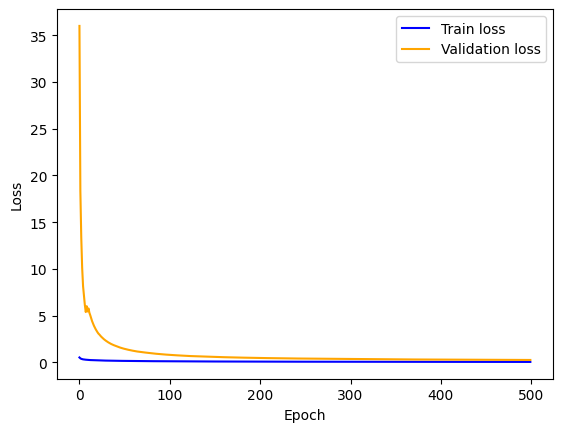

In [8]:
# Plot training and validation loss saved in writer_dict
from matplotlib import pyplot as plt
plt.figure()
plt.plot(writer_dict['loss_train'],color='blue',label='Train loss')
plt.plot(writer_dict['loss_valid'],color='orange',label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

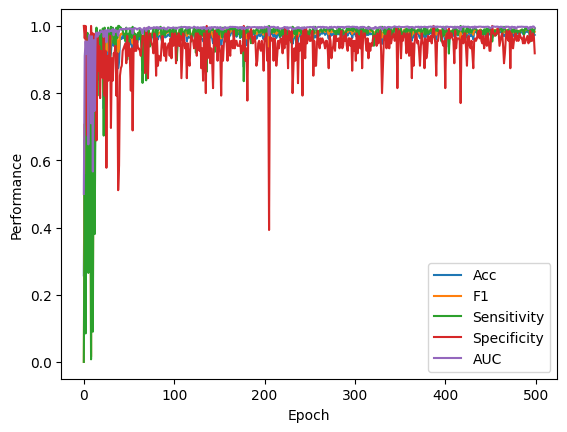

In [9]:
# plot evaluation metrics saved in writer_dict
plt.figure()
plt.plot(writer_dict['Acc'],label='Acc')
plt.plot(writer_dict['F1'],label='F1')
plt.plot(writer_dict['Sensitivity'],label='Sensitivity')
plt.plot(writer_dict['Specificity'],label='Specificity')
plt.plot(writer_dict['AUC'],label='AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.show()

In [10]:
# save writer_dict 
# see: https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object
import pickle

savePath = os.path.join(os.path.dirname(os.path.realpath('__file__')),f'writer_dict_{NUM_EPOCHS}_Epochs_size_{size}.pickle')

# write dictionary
with open(savePath, 'wb') as f:
    pickle.dump(writer_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# load dictionary
with open(savePath, 'rb') as f:
    loadedDict = pickle.load(f)


## Model inference
Now we want to use our trained model to predict new data.\
Therefore, we define a function *infer*, which gets a data loader and the trained model as input. \
You can use the code from the training loop for help.

In [11]:
def infer(data_loader, model):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for batch in data_loader:
            with torch.autocast(device_type='cuda'):

                inputs = batch['image'].to(device)
                targets = batch['label'].to(device, torch.float16)
                
                outputs = model(inputs)
                
                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs.sigmoid()), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        metric_dict = evalModel(y_true, y_score)

        y_pred = (y_score >= 0.5).astype(int)

        print('auc: %.3f  acc:%.3f, f1: %3f, sens.: %3f, spec.: %3f' %(metric_dict['AUC'],metric_dict['Acc'], metric_dict['F1'],metric_dict['Sensitivity'], metric_dict['Specificity']))
        

    return metric_dict, y_pred

In [13]:
# You can use the code belwo to load the best model
model = resnet50(spatial_dims=2,num_classes=1,n_input_channels=1).to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('==> Evaluating ...')
print('Validation performance:')
metrics_val, val_pred = infer(val_loader, model)
print('Test performance')
metrics_test, test_pred = infer(test_loader, model)

# Now we want to convert our dictionaries to a pandas dataframe and save the results as csv file
# see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
import pandas as pd
df_test = pd.DataFrame(metrics_test,index=[0])
df_test.to_csv(os.path.join(os.path.dirname(os.path.realpath('__file__')),f'testPerf_{NUM_EPOCHS}_Epochs_size_{size}.csv'))

df_val = pd.DataFrame(metrics_val,index=[0])
df_val.to_csv(os.path.join(os.path.dirname(os.path.realpath('__file__')),f'valPerf_{NUM_EPOCHS}_Epochs_size_{size}.csv'))


/tmp/ipykernel_1699051/3997562727.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


==> Evaluating ...
Validation performance:
auc: 0.994  acc:0.973, f1: 0.982188, sens.: 0.992288, spec.: 0.918519
Test performance
auc: 0.958  acc:0.877, f1: 0.909942, sens.: 0.997436, spec.: 0.675214


Now we want to have a closer look on our model performance and the predicted results from our test set. \
Write code, to visualize false positive (prediction = Pneumonia, label = Healthy) and false negative cases (prediction = Healthy, label = Pneumonia)

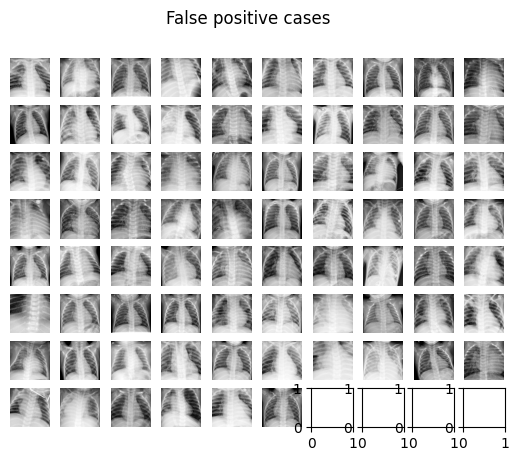

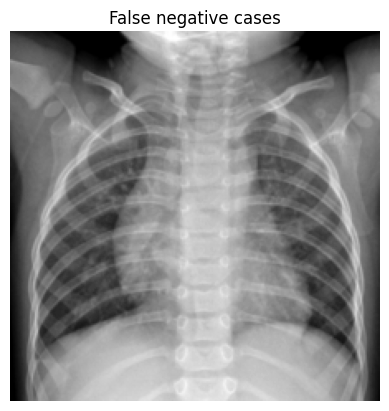

In [14]:
# Check false positive and false negative test cases
# save indices for fp and fn in a separate list
fp_cases = []
fn_cases = []
for cur_ind in range(len(test_dataset)):
    if test_pred[cur_ind] == 1 and test_dataset.labels[cur_ind]==0:
        fp_cases.append(cur_ind)
    elif test_pred[cur_ind] == 0 and test_dataset.labels[cur_ind]==1:
        fn_cases.append(cur_ind)

# plot fp cases:
imagesInARow=min(10,len(fp_cases))
rows=int(np.ceil(len(fp_cases)/imagesInARow))


if imagesInARow==1:
    fig = plt.figure()
    plt.title('False positive cases')
    plt.imshow(orig_img, cmap='gray')
    plt.axis('off')
else:
    fig, axs = plt.subplots(rows, imagesInARow)
    fig.suptitle('False positive cases')
    row=0
    col=0

    for i, idx in enumerate(fp_cases):
        orig_img = train_dataset.imgs[idx]

        if col>=imagesInARow:
            row+=1
            col=0

        if rows > 1:
            axs[row,col].imshow(orig_img, cmap='gray')
            axs[row,col].axis('off')
        else:
            axs[col].imshow(orig_img, cmap='gray')
            axs[col].axis('off')
        col+=1

    plt.show()

# plot fn cases:
imagesInARow=min(10,len(fn_cases))
rows=int(np.ceil(len(fn_cases)/imagesInARow))

if imagesInARow==1:
    fig = plt.figure()
    plt.title('False negative cases')
    plt.imshow(orig_img, cmap='gray')
    plt.axis('off')
else:
    fig, axs = plt.subplots(rows, imagesInARow)
    fig.suptitle('False negative cases',y=0.8)
    row=0
    col=0

    for i, idx in enumerate(fn_cases):
        orig_img = train_dataset.imgs[idx]

        if col>=imagesInARow:
            row+=1
            col=0

        if rows > 1:
            axs[row,col].imshow(orig_img, cmap='gray')
            axs[row,col].axis('off')
        else:
            axs[col].imshow(orig_img, cmap='gray')
            axs[col].axis('off')
            
        col+=1

    plt.show()

# Optional Tasks
When you have finished everything else, you can continue working on one of the following tasks, for example, or come up with something of your own
## Task 1: Multi-label classification
So far we have only dealt with a binary classification problem. However, we often also have to deal with multi-label problems. Multi-label classification is a type of classification where each data point can belong to multiple classes simultaneously, meaning the model predicts a set of labels rather than just one. For example, a photo might be labeled as both "cat" and "dog" if it contains both animals.
You can use and adapt the code you have developed here to solve a multi-label classification problem using the ChestMNIST from the [MedMnist](https://medmnist.com/) data set.

## Task 2: Large Language Models
Use Large Language Models (LLMs) to generate radiological reports for the PneumoniaMNIST dataset. See for example  https://huggingface.co/microsoft/Phi-3-vision-128k-instruct

## Task 3: Generative data augmentation
For generative data augmentation you can for example train a conditional Generative Adversarial Network (GAN) to generate new healty and new pneumonia images, see for example: https://github.com/qbxlvnf11/conditional-GAN/blob/main/conditional-GAN-generating-fashion-mnist.ipynb 
GANs are relatively difficult to train, which is why you can also consider using a pre-trained GAN to achieve better results. You can take a look at this: GANs are relatively difficult to train, which is why you can also consider using a pre-trained GAN to achieve better results. You can take a look at this: https://github.com/Project-MONAI/tutorials/blob/main/modules/mednist_GAN_tutorial.ipynb.


